<center><font size="6"><b>CV SEGA</b></font></center>
<p></p>
<center><font size="5"><b>Modélisation pour détection des bennes</b></font></center>
<br>
<br>
<br>

# Intentions

Détecter et entourer les bennes via des bounding box.

# Logs

Voir CV_SEGA_model_objdetect_versions.md

# Configuration du notebook

In [1]:
# Mode d'éxécution du notebook : "drive" ou "local"
work_mode = "local"

# Localisation des modèles pour les sauvegardes et les chargements
if work_mode == "drive":
    model_loc = "/drive/My Drive/CV_DS/..."
elif work_mode == "local":
    model_loc = "_models"

In [2]:
%%javascript
// Récupération du nom du notebook
var kernel = IPython.notebook.kernel;
var body = document.body,  
    attribs = body.attributes;
var command = "theNotebook = " + "'"+attribs['data-notebook-name'].value+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
# Récupération du nom notebook pour les sauvegardes de modèles et connection au drive et montage du drive
if work_mode == "drive":
    # Montage du drive
    from requests import get
    theNotebook = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    theNotebook = theNotebook[0:-6]
    print("Nom du notebook : ",theNotebook)
    
    # Montage du drive
    from google.colab import  drive
    drive.mount('/content/drive')

# Installer

In [4]:
if work_mode == "drive":
    !pip install swifter


# Modules et fonctions

## Import des modules


In [5]:
# Classics
import pandas as pd
import numpy as np
import random

# Opérations sur fichiers/dossiers
import os
from joblib import load, dump
import json

# Viz
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import missingno as msno
%matplotlib inline

# Autres
from tqdm import tqdm
from collections import Counter
import pprint

# Tensorflow
import tensorflow as tf

# Preprocess
from sklearn.model_selection import train_test_split


E:\programmes\Miniconda3\envs\cv_tflow\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


## La cuisine

In [6]:
# Fonction d'affichage des BB
def show_img_bb (img, x, y, w, h,name):
    
    # Calcul des coordonnées
    x1 = np.abs(x)
    y1 = np.abs(y)
    w = np.abs(w)
    h = np.abs(h)
    x2= x1+w
    y2= y1+h
    
    # Affichage des coordonnées
    print(f"Coordonnées BB {name}")
    print(f'x:{x}',f'y:{y}',f'w:{w}',f'h:{h}')
    print(f'x1:{x1}',f'x2:{x2}',f'y1:{y1}',f'y2:{y2}')
    
    plt.imshow(img)
    plt.plot([x1,x2,x2,x1,x1], [y1,y1,y2,y2,y1], "r")
    plt.title("Image : " + name)
#     plt.show()

## Test GPU

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
sys_details = tf.sysconfig.get_build_info()
if tf.test.gpu_device_name():
    device_name = tf.test.gpu_device_name()
    print(f'GPU found : {device_name}')
    pprint.print(sys_details)
else:
    tf.config.list_physical_devices('CPU')
    print("No GPU found, CPU mode activated")
    pprint.pprint(sys_details)

No GPU found, CPU mode activated
OrderedDict([('cpu_compiler',
              'C:/Program Files (x86)/Microsoft Visual '
              'Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '64_112'),
             ('cudart_dll_name', 'cudart64_112.dll'),
             ('cudnn_dll_name', 'cudnn64_8.dll'),
             ('cudnn_version', '64_8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', False),
             ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'),
             ('nvcuda_dll_name', 'nvcuda.dll')])


# Chargement du dataset

In [8]:
# Lecture des données
if work_mode == "local":
#     data_path = "Z:/_pyworld/_kindergarten/_T_Datascientest/Projet cv SEGA/SEGA/datasets/container"
    data_path = "E:/OneDrive/_forge/SEGA/datasets/container"

df = pd.read_csv(data_path + '/df_1_light.csv',index_col=0,converters={'bbox': pd.eval})
df = df.astype({'file_name':'string'})
df["file_name"] = df["file_name"].apply(lambda x: data_path + "/" + x)
display (df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1483 entries, 0 to 1482
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  1483 non-null   object
 1   bbox       1483 non-null   object
dtypes: object(2)
memory usage: 34.8+ KB


None

,file_name,bbox
0,E:/OneDrive/_forge/SEGA/datasets/container/000...,"[10, 0, 535, 289]"
1,E:/OneDrive/_forge/SEGA/datasets/container/000...,"[18, 46, 400, 224]"
2,E:/OneDrive/_forge/SEGA/datasets/container/000...,"[1, 51, 703, 606]"
3,E:/OneDrive/_forge/SEGA/datasets/container/000...,"[0, 135, 493, 287]"
4,E:/OneDrive/_forge/SEGA/datasets/container/000...,"[556, 77, 233, 186]"


In [9]:
# Filtrage uniquement sur les formats JPEG
df = df[df["file_name"].str.contains(".jpeg")]

In [9]:
# Récupération de la liste des doublons
list_double = list(df.loc[df.astype(str).duplicated(subset = ["file_name"],keep = 'last'),:].index)

print("liste de doublons :", list_double)

liste de doublons : [3, 4, 6, 8, 12, 16, 17, 20, 21, 31, 33, 37, 40, 41, 42, 44, 50, 55, 59, 66, 69, 70, 72, 73, 76, 77, 79, 93, 107, 109, 117, 120, 127, 128, 131, 132, 134, 135, 138, 139, 140, 148, 149, 150, 151, 152, 153, 154, 161, 169, 171, 180, 183, 197, 200, 202, 203, 208, 212, 224, 241, 242, 243, 244, 258, 269, 272, 277, 282, 297, 299, 300, 316, 327, 331, 336, 339, 344, 351, 366, 370, 377, 384, 386, 391, 392, 401, 410, 417, 433, 434, 440, 452, 453, 460, 474, 476, 477, 480, 481, 483, 486, 488, 490, 491, 492, 493, 495, 507, 512, 514, 516, 517, 518, 524, 525, 536, 553, 563, 564, 565, 569, 573, 575, 579, 580, 581, 587, 594, 596, 601, 608, 609, 629, 630, 634, 648, 650, 652, 658, 660, 664, 665, 666, 673, 676, 677, 683, 689, 694, 703, 704, 707, 711, 715, 716, 718, 726, 727, 732, 739, 740, 748, 751, 756, 761, 762, 771, 774, 781, 783, 784, 805, 807, 810, 814, 816, 818, 819, 823, 829, 834, 835, 836, 845, 846, 848, 849, 853, 854, 858, 859, 886, 891, 902, 905, 920, 927, 931, 932, 935, 936, 9

In [10]:
# On chute les cas ou il y a plus d'une BB
df.drop(index=list_double, inplace = True)
df.reset_index(drop=True, inplace=True)

<AxesSubplot:>

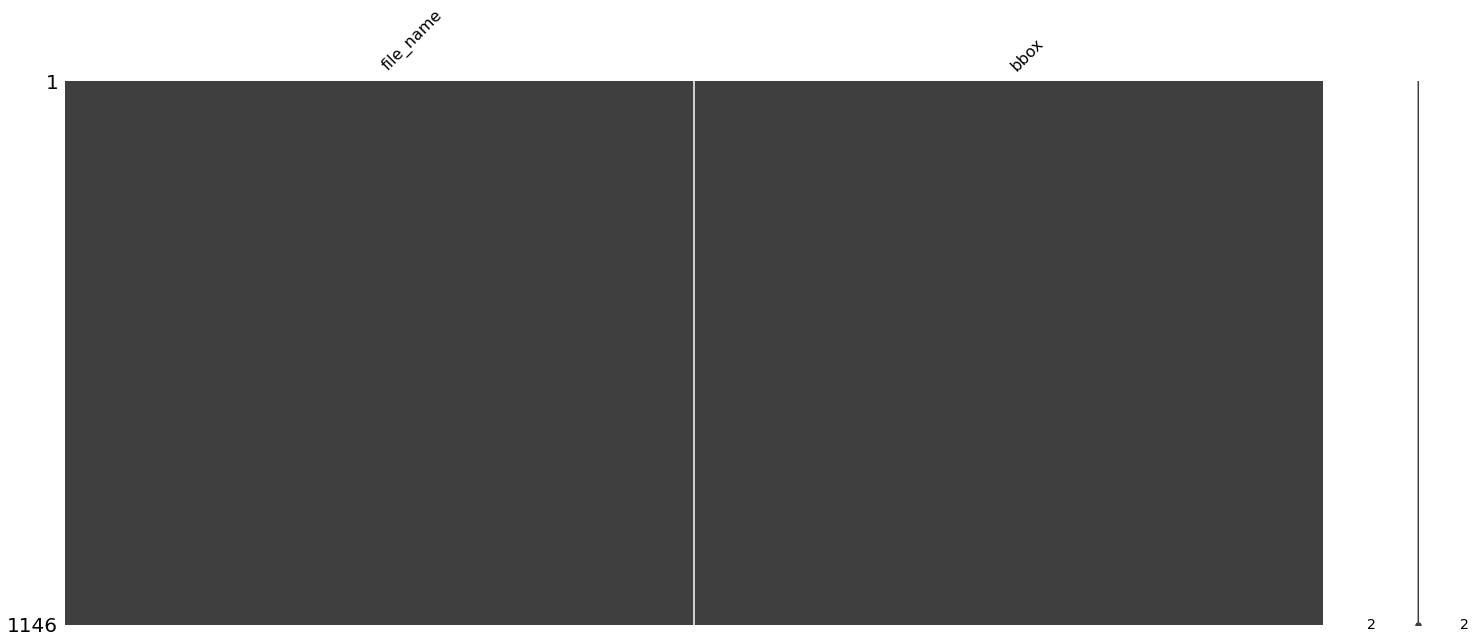

In [11]:
msno.matrix(df)

# Preprocessing

## Séparation

In [12]:
################ Réalisation des sets d'entrainnement et de tests
"""
    taille du set de test => 10 % des données restantes
    random_state => 42
"""

# Séparer la variable explicative de la variable à prédire
X, y = df["file_name"], df["bbox"].apply(lambda x: np.array(x)).to_list()

X_train, X_test, y_train, y_test  = train_test_split(np.array(X), np.array(y), test_size=0.1,random_state = 42)

## Fonction de chargement

In [13]:
# Fonction de chargement des images via un numpy array ou un chemin
@tf.function
def magic_loader (X, y, fromfile = False, norm = True, resize = None):   
    
    # ==== Chargement de l'image
    if fromfile == True:
        image = tf.io.read_file(X, name=None)
        image = tf.io.decode_image(image,channels=3,expand_animations=False)     
     
    else:
        image = tf.convert_to_tensor(X)

    # ==== Normalisation    
    if norm :
        image = tf.divide(image, 255)
    
    # ==== Redimensionnement  
    if resize!= None:
        # Récupération de l'ancienne taille de l'image
        old_size = tf.shape(image)[:2]

        # Définition de la taille cible de l'image
        img_size = tf.constant(resize)

        # Redimensionnement
        image = tf.image.resize(image,
                             img_size,
                             method='nearest',
                             preserve_aspect_ratio=False,
                             antialias=False,
                             name=None)
        
        # Calcul du ratio de redimensionnement pour adapter les bounding boxs
        ratio = tf.math.divide(img_size,old_size)
        ratio = tf.cast(ratio, dtype="float32")
        

        
        # Redimensionnement des bounding boxs
        y = tf.convert_to_tensor(y)
        y = tf.cast(y, dtype="float32")/255
        x_sized = y[0]*ratio[1]
        y_sized = y[1]*ratio[0]
        w_sized = y[2]*ratio[1]
        h_sized = y[3]*ratio[0]
        y_new = tf.stack([x_sized,y_sized,w_sized,h_sized],0)

    else:
        y_new = y

    return image, y_new 




==== Avant ====
(1920, 1440, 3)
[0, 639, 1419, 656]
Coordonnées BB E:/OneDrive/_forge/SEGA/datasets/container/01867.jpeg
x:0 y:639 w:1419 h:656
x1:0 x2:1419 y1:639 y2:1295


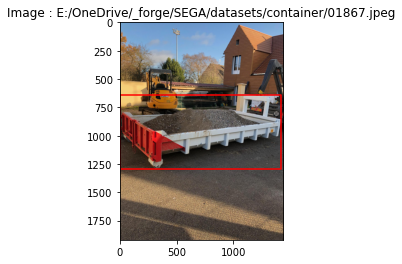

==== Après ====
(256, 256, 3)
tf.Tensor([0.         0.33411765 0.98928106 0.34300655], shape=(4,), dtype=float32)
Coordonnées BB E:/OneDrive/_forge/SEGA/datasets/container/01867.jpeg
x:0.0 y:85.20000457763672 w:252.26666259765625 h:87.46666717529297
x1:0.0 x2:252.26666259765625 y1:85.20000457763672 y2:172.6666717529297


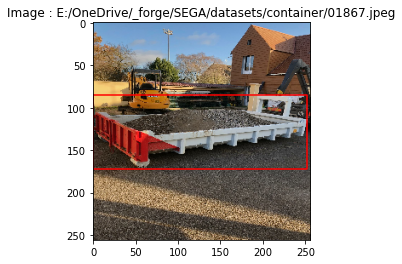

In [14]:
# ================================================================================================
# Définition de l'image pour test de la fonction de chargement d'image
i = random.choices(list(df.index), k=1)[0]
img_path = df.loc[i,"file_name"]
imgRsize = (256, 256)

# ================================================================================================
# Test de la fonction
image = plt.imread(img_path)

print("==== Avant ====")
print(image.shape)
print(df.loc[i,"bbox"])
show_img_bb (image, df.loc[i,"bbox"][0], df.loc[i,"bbox"][1], df.loc[i,"bbox"][2], df.loc[i,"bbox"][3], df.loc[i,"file_name"] )
plt.show()

# Application de la fonction fonctions
image_new, y_new = magic_loader(img_path, df.loc[i,"bbox"],
                                fromfile = True,
                                norm = True,
                                resize = (imgRsize[0], imgRsize[0])
                               )

print("==== Après ====")
print(image_new.shape)
print(y_new)
show_img_bb (image_new, y_new[0]*255, y_new[1]*255, y_new[2]*255, y_new[3]*255, df.loc[i,"file_name"] )
plt.show()

## Générateur de données

In [15]:
batch_size = 8
imgRsize = (256, 256)
AUTO = tf.data.experimental.AUTOTUNE

# Train
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_train = dataset_train.shuffle(len(X_train)).map(lambda x, y : magic_loader(x,
                                                                                   y,
                                                                                   fromfile = True,
                                                                                   norm = True,
                                                                                   resize = imgRsize
                                                                                  ), num_parallel_calls=-1
                                                       )\
                                                    .batch(batch_size,drop_remainder=True)\
                                                    .cache()\
                                                    .prefetch(AUTO)\
                                                    .repeat(-1)
# Test
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
dataset_test = dataset_test.shuffle(len(X_test)).map(lambda x, y : magic_loader(x,
                                                                                y,
                                                                                fromfile = True,
                                                                                norm = True,
                                                                                resize = imgRsize
                                                                               ))\
                                                    .batch(batch_size,drop_remainder=True)\
                                                    .cache()\
                                                    .prefetch(AUTO)\
                                                    .repeat(-1)
# # Val
# dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
# dataset_val = dataset_test.shuffle(len(X_val)).map(lambda x, y : magic_loader(x,
#                                                                               y,
#                                                                               fromfile = True,
#                                                                               norm = True,
#                                                                               resize = imgRsize
#                                                                              ))\
#                                                     .batch(batch_size,drop_remainder=True)\
#                                                     .cache()\
#                                                     .prefetch(AUTO)\
#                                                     .repeat(-1)


Coordonnées BB X
x:0.0 y:60.302223205566406 w:256.0 h:195.69778442382812
x1:0.0 x2:256.0 y1:60.302223205566406 y2:256.0


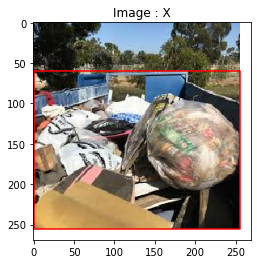

Coordonnées BB X
x:54.36293411254883 y:63.340206146240234 w:197.68341064453125 h:190.02061462402344
x1:54.36293411254883 x2:252.0463409423828 y1:63.340206146240234 y2:253.36082458496094


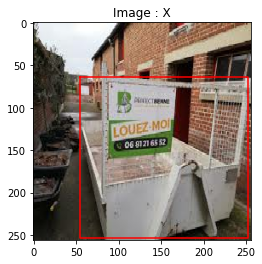

Coordonnées BB X
x:0.0 y:0.0 w:240.4258575439453 h:256.0
x1:0.0 x2:240.4258575439453 y1:0.0 y2:256.0


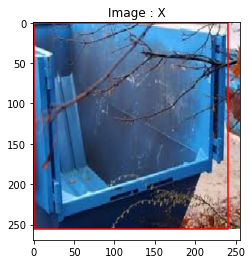

Coordonnées BB X
x:20.210527420043945 y:62.9333381652832 w:215.57896423339844 h:192.7111053466797
x1:20.210527420043945 x2:235.78948974609375 y1:62.9333381652832 y2:255.64443969726562


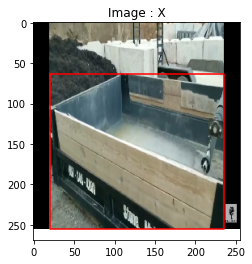

Coordonnées BB X
x:47.0588264465332 y:76.10810852050781 w:178.8235321044922 h:177.12432861328125
x1:47.0588264465332 x2:225.88235473632812 y1:76.10810852050781 y2:253.23243713378906


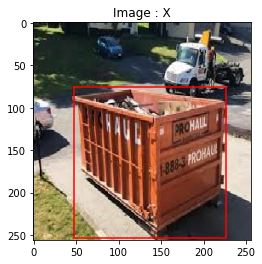

Coordonnées BB X
x:0.3076923191547394 y:0.41025644540786743 w:255.3845977783203 h:255.17950439453125
x1:0.3076923191547394 x2:255.69229125976562 y1:0.41025644540786743 y2:255.5897674560547


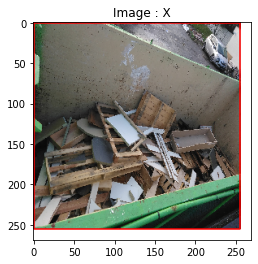

Coordonnées BB X
x:0.0 y:0.0 w:254.99212646484375 h:254.7070770263672
x1:0.0 x2:254.99212646484375 y1:0.0 y2:254.7070770263672


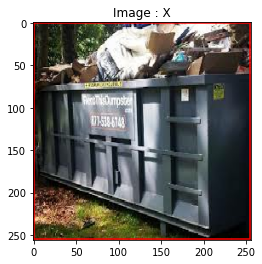

Coordonnées BB X
x:0.0 y:70.84276580810547 w:187.5723114013672 h:181.9370880126953
x1:0.0 x2:187.5723114013672 y1:70.84276580810547 y2:252.77984619140625


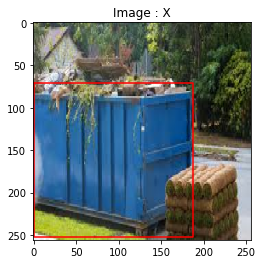

In [16]:
# Visualisation des sorties du générateur train

X_t, y_t = next(iter(dataset_train))

for img,bbox in zip(X_t, y_t):
#     print(i,img.shape)
    show_img_bb (img, bbox[0]*255, bbox[1]*255, bbox[2]*255, bbox[3]*255, "X" )
    plt.show()

In [17]:
# Définition d'un générateur python
def generator(dataset):
    iterator = iter(dataset)
    while True:
        X, y = next(iterator)
        yield X, y

# Définition du générateur final.
gen_train = generator(dataset_train)
gen_test = generator(dataset_test)

# Modélisation

## Partrie encoder

In [18]:
from tensorflow.keras.applications.resnet50 import ResNet50

# Load the model efficientNet
efficientNet = ResNet50(include_top=False, input_shape=(imgRsize[0],imgRsize[1],3))

# Freeze the blackbone
for layer in efficientNet.layers:
    layer.trainable = False

## Partie régression

In [19]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model

model = Sequential()
model.add(efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

## Fonction de perte

In [20]:
def coord_loss(y_true, y_pred):
    
    # Conversion en tenseurs
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    
    # Répartition des valeurs
    xpred = y_pred[:,0]
    xtrue = y_true[:,0]
    ypred = y_pred[:,1]
    ytrue = y_true[:,1]
    wpred = y_pred[:,2]
    wtrue = y_true[:,2]
    hpred = y_pred[:,3]
    htrue = y_true[:,3]
    
    # Calcul des différents membres de la formule
    a = tf.math.square(xpred - xtrue)
    b = tf.math.square(ypred - ytrue)
    c = tf.math.square(tf.math.sqrt(tf.math.abs(wpred))-tf.math.sqrt(wtrue))
    d = tf.math.square(tf.math.sqrt(tf.math.abs(hpred))-tf.math.sqrt(htrue))

    return tf.reduce_mean((a + b + c + d), axis=-1)


## Callbacks

In [21]:
from tensorflow.keras import callbacks

In [22]:
# Réduction du lr sur un plateau
lr_plateau = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         patience=4,
                                         verbose=2,
                                         mode='min')

In [22]:
# Callback pour l'arrêt anticipé si les perfos ne s'améliorent pas.
early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10,
                                         mode='min',
                                         restore_best_weights=True)

In [23]:
import tensorflow_addons as tfa

INIT_LR = 1e-4
MAX_LR = 1e-2

steps_per_epoch = len(X_train) // batch_size
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
                                          maximal_learning_rate=MAX_LR,
                                          scale_fn=lambda x: 1/(2.**(x-1)),
                                          step_size=2 * steps_per_epoch
                                         )


## Compilation

In [24]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

model.compile(loss=coord_loss,
              optimizer=Adam(clr),
              metrics = [tf.keras.metrics.MeanSquaredError()]
             )

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

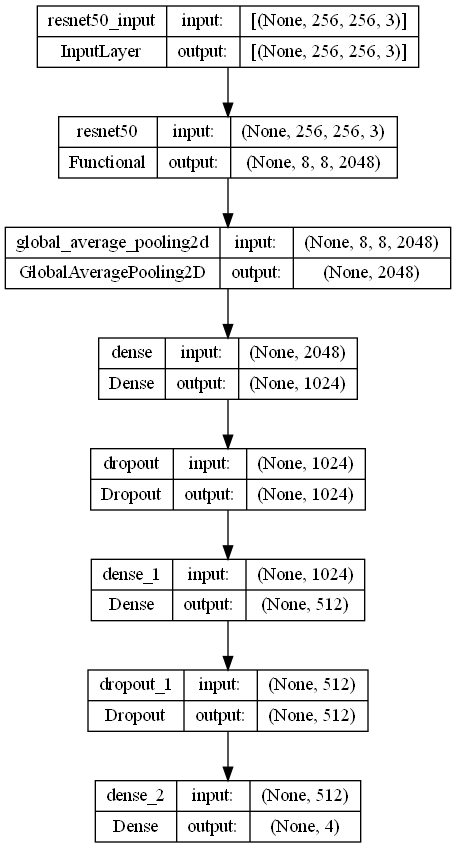

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## Entrainement

In [27]:
nb_epochs = 40
history = model.fit(dataset_train,
                    steps_per_epoch = (int(len(X_train)//batch_size)),
                    epochs=nb_epochs,
                    validation_data = dataset_train,
                    validation_steps = (int(len(X_test)//batch_size)),
                    callbacks=[early_stopping]
                   )

Epoch 1/40
128/128 [==============================] - 178s 1s/step - loss: 0.4116 - mean_squared_error: 0.8103 - val_loss: 0.1116 - val_mean_squared_error: 0.4737
Epoch 2/40
128/128 [==============================] - 155s 1s/step - loss: 0.1494 - mean_squared_error: 0.4618 - val_loss: 0.1220 - val_mean_squared_error: 0.4386
Epoch 3/40
128/128 [==============================] - 154s 1s/step - loss: 0.1266 - mean_squared_error: 0.4598 - val_loss: 0.1139 - val_mean_squared_error: 0.4397
Epoch 4/40
128/128 [==============================] - 156s 1s/step - loss: 0.1250 - mean_squared_error: 0.4578 - val_loss: 0.1101 - val_mean_squared_error: 0.4215
Epoch 5/40
128/128 [==============================] - 154s 1s/step - loss: 0.1245 - mean_squared_error: 0.4581 - val_loss: 0.1110 - val_mean_squared_error: 0.4271
Epoch 6/40
128/128 [==============================] - 160s 1s/step - loss: 0.1258 - mean_squared_error: 0.4593 - val_loss: 0.1127 - val_mean_squared_error: 0.4362
Epoch 7/40
128/128 [==

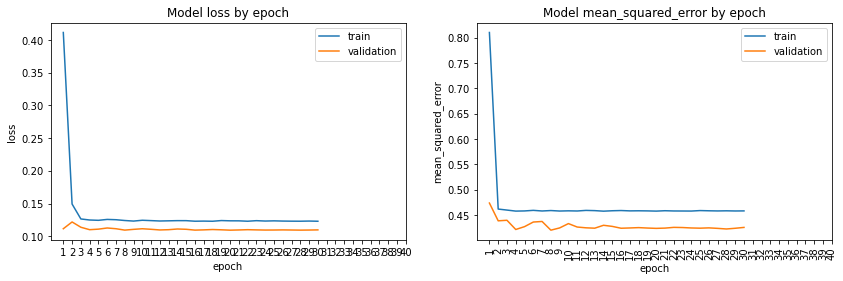

In [28]:
# Config
first_var = 'loss'
second_var = 'mean_squared_error'
history = history

# Mise à l'échelle des nb d'epochs
tick_locs = list(range(0,nb_epochs))
tick_lbls = list(range(1,nb_epochs+1))

plt.figure(figsize=(14,4))
# Graphe var 1
plt.subplot(121)
plt.plot(history.history[first_var])
plt.plot(history.history['val_'+first_var])
plt.title(f'Model {first_var} by epoch')
plt.ylabel(first_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls)
plt.legend(['train', 'validation'], loc='best')

# Graphe var 2
plt.subplot(122)
plt.plot(history.history[second_var])
plt.plot(history.history['val_'+second_var])
plt.title(f'Model {second_var} by epoch')
plt.ylabel(second_var)
plt.xlabel('epoch')
plt.xticks(tick_locs, tick_lbls, rotation = 90)
plt.legend(['train', 'validation'], loc='best')
plt.show()

## Inférence

In [29]:
X_t, y_t = next(gen_test)

==== Image et BB source ====
Coordonnées BB X
x:92.1390609741211 y:68.54644775390625 w:163.86093139648438 h:121.70491790771484
x1:92.1390609741211 x2:256.0 y1:68.54644775390625 y2:190.25137329101562


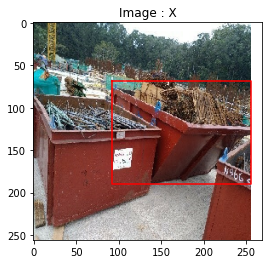

==== Image et BB après prédiction ====
1/1 [==============================] - 4s 4s/step
Coordonnées BB X
x:37.68907941877842 y:57.464453279972076 w:177.43222385644913 h:160.87990164756775
x1:37.68907941877842 x2:215.12130327522755 y1:57.464453279972076 y2:218.34435492753983


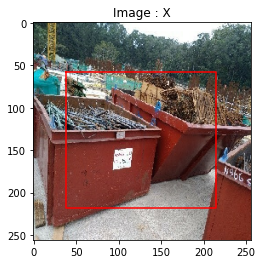

In [30]:
# Définition de l'image et des coordonnées pour test du modèle
i = random.choices(list(range(batch_size)), k=1)[0]
img_ori = X_t[i]
coord_ori = y_t[i]

# Affichage de la BB d'origine
print("==== Image et BB source ====")
show_img_bb (img_ori, coord_ori[0]*255, coord_ori[1]*255, coord_ori[2]*255, coord_ori[3]*255, "X" )
plt.show()

# Affichage de la BB prédite
print("==== Image et BB après prédiction ====")
x, y, w, h = model.predict(tf.expand_dims(X_t[i], axis=0))[0]
# print(f"Probabilité de présence d'objet : {p}")
show_img_bb (img_ori, x*255, y*255, w*255, h*255, "X" )
plt.show()

==== Image et BB après prédiction ====
1/1 [==============================] - 0s 349ms/step
Coordonnées BB X
x:37.68907941877842 y:57.464453279972076 w:177.43222385644913 h:160.87990164756775
x1:37.68907941877842 x2:215.12130327522755 y1:57.464453279972076 y2:218.34435492753983


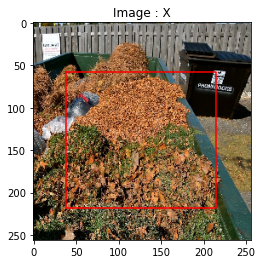

==== Image et BB après prédiction ====
1/1 [==============================] - 0s 234ms/step
Coordonnées BB X
x:37.68907941877842 y:57.464453279972076 w:177.43222385644913 h:160.87990164756775
x1:37.68907941877842 x2:215.12130327522755 y1:57.464453279972076 y2:218.34435492753983


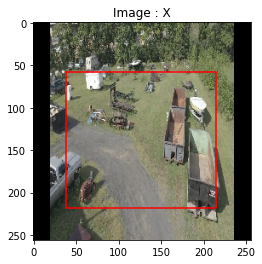

==== Image et BB après prédiction ====
1/1 [==============================] - 0s 297ms/step
Coordonnées BB X
x:37.68907941877842 y:57.464453279972076 w:177.43222385644913 h:160.87990164756775
x1:37.68907941877842 x2:215.12130327522755 y1:57.464453279972076 y2:218.34435492753983


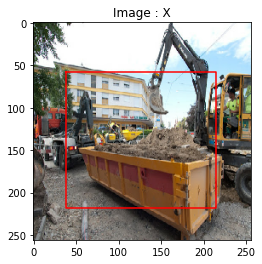

==== Image et BB après prédiction ====
1/1 [==============================] - 0s 290ms/step
Coordonnées BB X
x:37.68907941877842 y:57.464453279972076 w:177.43222385644913 h:160.87990164756775
x1:37.68907941877842 x2:215.12130327522755 y1:57.464453279972076 y2:218.34435492753983


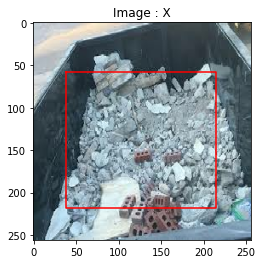

==== Image et BB après prédiction ====
1/1 [==============================] - 0s 257ms/step
Coordonnées BB X
x:37.68907941877842 y:57.464453279972076 w:177.43222385644913 h:160.87990164756775
x1:37.68907941877842 x2:215.12130327522755 y1:57.464453279972076 y2:218.34435492753983


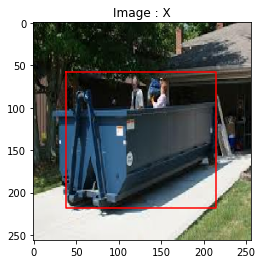

==== Image et BB après prédiction ====
1/1 [==============================] - 0s 247ms/step
Coordonnées BB X
x:37.68907941877842 y:57.464453279972076 w:177.43222385644913 h:160.87990164756775
x1:37.68907941877842 x2:215.12130327522755 y1:57.464453279972076 y2:218.34435492753983


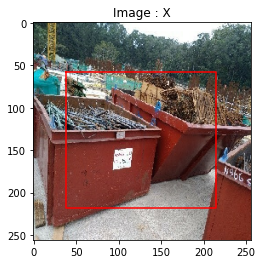

==== Image et BB après prédiction ====
1/1 [==============================] - 0s 313ms/step
Coordonnées BB X
x:37.68907941877842 y:57.464453279972076 w:177.43222385644913 h:160.87990164756775
x1:37.68907941877842 x2:215.12130327522755 y1:57.464453279972076 y2:218.34435492753983


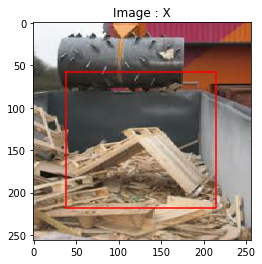

==== Image et BB après prédiction ====
1/1 [==============================] - 0s 290ms/step
Coordonnées BB X
x:37.68907941877842 y:57.464453279972076 w:177.43222385644913 h:160.87990164756775
x1:37.68907941877842 x2:215.12130327522755 y1:57.464453279972076 y2:218.34435492753983


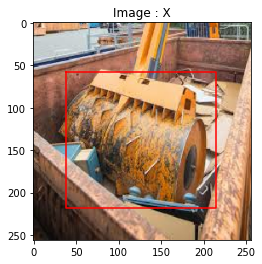

In [31]:
for img in X_t:
    print("==== Image et BB après prédiction ====")
#     print(f"Probabilité de présence d'objet : {p}")
    x, y, w, h = model.predict(tf.expand_dims(img, axis=0))[0]
    show_img_bb (img, x*255, y*255, w*255, h*255, "X" )
    plt.show()

In [34]:
import time
import cv2, urllib, json

def url_to_image(url):
    resp = urllib.request.urlopen(url) 
    img = np.asarray(bytearray(resp.read()), dtype="uint8")
    img = cv2.imdecode(img, -1)
    img = cv2.resize(img, (256,256))
    img = img[..., [2,1,0]]
    return tf.keras.applications.efficientnet.preprocess_input(img)

In [35]:
# Exemple
img = url_to_image("https://www.okvoyage.com/wp-content/uploads/2020/11/beau-chateau-france-vaux-le-vicomte-1024x683.jpeg")


In [41]:
x, y, w, h = model.predict(tf.expand_dims(img/255, axis=0))[0]

1/1 [==============================] - 4s 4s/step


Coordonnées BB X
x:37.68907941877842 y:57.464453279972076 w:177.43222385644913 h:160.87990164756775
x1:37.68907941877842 x2:215.12130327522755 y1:57.464453279972076 y2:218.34435492753983


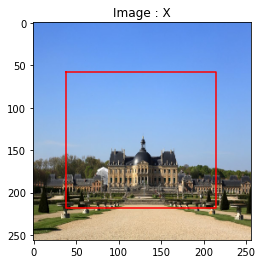

In [43]:
show_img_bb (img, x*255, y*255, w*255, h*255, "X" )
plt.show()

# Bac à sable